<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

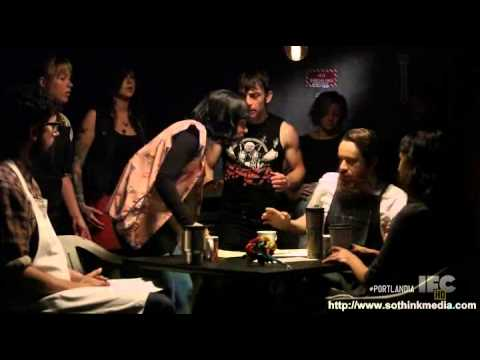

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\David\\Documents\\Jupyter_Notebook_Stuff\\Untitled Folder 1'

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


First, I want to clean the data:

1. Delete the dates at the beginning of each review

2. Convert the star_rating column to floats

In [2]:
# Test on a single row first.

row = shops.loc[0]
row

coffee_shop_name                      The Factory - Cafe With a Soul 
full_review_text     11/25/2016 1 check-in Love love loved the atm...
star_rating                                          5.0 star rating 
Name: 0, dtype: object

In [3]:
# I need to isolate the date. I'll try splitting at the first white space.

row[1].split(' ', 1)

['',
 '11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? ']

In [4]:
# This didn't work. Maybe the first two white spaces?

row[1].split(' ', 2)

# There we go!

['',
 '11/25/2016',
 '1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? ']

In [5]:
# Similarly, I need to isolate the number in the star_rating.

row[2].split(' ', 2)

['', '5.0', 'star rating ']

In [6]:
def delete_date(string):
    split = string.split(' ', 2)
    return split[2]

def convert_float(string):
    split = string.split(' ', 2)
    return float(split[1])

shops['full_review_text'] = shops['full_review_text'].apply(delete_date)

shops['star_rating'] = shops['star_rating'].apply(convert_float)

shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0


In [7]:
shops.dtypes

# Success!

coffee_shop_name     object
full_review_text     object
star_rating         float64
dtype: object

Next, I want to create a new column where, for each shop, I average the star rating of all their reviews.

I tried converting to a sqlite3 database and using SQL for this, but it didn't work (see code at bottom of notebook). So I'll just use Pandas.

In [8]:
# Let's take a closer look at the coffee shop name column.

shops['coffee_shop_name'].value_counts()

Epoch Coffee                            400
Halcyon                                 300
The Factory - Cafe With a Soul          244
Venezia Italian Gelato                  200
Houndstooth Coffee                      200
Caffé Medici                            143
Apanas Coffee & Beer                    136
Sa-Ten                                  100
Cenote                                  100
The Hideout Coffeehouse                 100
The Steeping Room                       100
Vintage Heart Coffee                    100
Anderson’s Coffee Company               100
Live Oak Market                         100
Juan Pelota                             100
Seventh Flag Coffee Co                  100
Summer Moon Coffee Bar                  100
Irie Bean Coffee Bar                    100
Kick Butt Coffee Music & Booze          100
Cream Whiskers                          100
Café Crème                              100
Once Over Coffee Bar                    100
Sorrento’s Coffee               

In [16]:
group_by = shops.groupby('coffee_shop_name').mean()

group_by.head()

,star_rating
coffee_shop_name,
Alta’s Cafe,3.930000
Anderson’s Coffee Company,4.620000
Apanas Coffee & Beer,4.580882
Arturo’s Underground Cafe,4.300000
Bennu Coffee,4.130000


In [22]:
group_by = group_by.reset_index()

group_by.head()

,coffee_shop_name,star_rating
0,Alta’s Cafe,3.930000
1,Anderson’s Coffee Company,4.620000
2,Apanas Coffee & Beer,4.580882
3,Arturo’s Underground Cafe,4.300000
4,Bennu Coffee,4.130000


In [23]:
avg_ratings = []

for i in range(len(shops)):
    for j in range(len(group_by)):
        if shops.loc[i, 'coffee_shop_name'] == group_by.loc[j, 'coffee_shop_name']:
            avg_ratings.append(group_by.loc[j, 'star_rating'])
            
shops['avg_rating'] = avg_ratings

shops.head()

,coffee_shop_name,full_review_text,star_rating,avg_rating
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,4.360656
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,4.360656
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,4.360656
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,4.360656
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,4.360656


In [24]:
shops.tail()

,coffee_shop_name,full_review_text,star_rating,avg_rating
7611,The Steeping Room,I actually step into this restaurant by chance...,4.0,3.96
7612,The Steeping Room,"Ok, The Steeping Room IS awesome. How do they ...",5.0,3.96
7613,The Steeping Room,"Loved coming here for tea, and the atmosphere ...",4.0,3.96
7614,The Steeping Room,The food is just average. The booths didn't fe...,3.0,3.96
7615,The Steeping Room,I finally stopped in for lunch with my colleag...,4.0,3.96


In [26]:
# Now, time to make tokens.

import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load('en_core_web_lg')

tokenizer = Tokenizer(nlp.vocab)

In [30]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop is False) & (token.is_punct is False):
            doc_tokens.append(token.text.lower())
            
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

shops.head()

,coffee_shop_name,full_review_text,star_rating,avg_rating,tokens
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,4.360656,"[1, check-in, love, love, loved, atmosphere!, ..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,4.360656,"[listed, date, night:, austin,, ambiance, aust..."
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,4.360656,"[1, check-in, listed, brunch, spots, loved, ec..."
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,4.360656,"[cool, decor!, good, drinks, nice, seating, ,..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,4.360656,"[1, check-in, located, northcross, mall, shopp..."


In [25]:
# This is basically a direct copy from the lecture notebook.

from collections import Counter

def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    temp2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(temp2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [31]:
wc = count(shops['tokens'])

wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
43,,4343,14990,1.0,0.036868,0.036868,0.570247
18,coffee,4210,8058,2.0,0.019819,0.056687,0.552784
93,place,3029,4264,3.0,0.010487,0.067174,0.397715
113,great,2438,3250,4.0,0.007993,0.075167,0.320116
252,it's,2061,3117,5.0,0.007666,0.082833,0.270614


In [33]:
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
43,,4343,14990,1.0,0.036868,0.036868,0.570247
18,coffee,4210,8058,2.0,0.019819,0.056687,0.552784
93,place,3029,4264,3.0,0.010487,0.067174,0.397715
113,great,2438,3250,4.0,0.007993,0.075167,0.320116
252,it's,2061,3117,5.0,0.007666,0.082833,0.270614
161,like,2034,2902,6.0,0.007137,0.089971,0.267069
164,good,2084,2779,7.0,0.006835,0.096806,0.273634
9,1,1998,2035,8.0,0.005005,0.101811,0.262342
33,check-in,1957,1961,9.0,0.004823,0.106634,0.256959
27,love,1434,1806,10.0,0.004442,0.111076,0.188288


In [32]:
wc.loc[43, 'word']

' '

In [34]:
# Let's add some additional stop works: the whitespace and the contractions.

STOP_WORDS = nlp.Defaults.stop_words.union([' ', "it's", "i'm", "i've"])

In [35]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct is False):
            doc_tokens.append(token.text.lower())
            
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [36]:
wc = count(shops['tokens'])

wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
18,coffee,4210,8058,1.0,0.020919,0.020919,0.552784
92,place,3029,4264,2.0,0.011069,0.031988,0.397715
112,great,2438,3250,3.0,0.008437,0.040425,0.320116
160,like,2034,2902,4.0,0.007534,0.047959,0.267069
163,good,2084,2779,5.0,0.007214,0.055173,0.273634
9,1,1998,2035,6.0,0.005283,0.060456,0.262342
33,check-in,1957,1961,7.0,0.005091,0.065547,0.256959
27,love,1434,1806,8.0,0.004688,0.070236,0.188288
784,little,1230,1479,9.0,0.003840,0.074075,0.161502
337,don't,1133,1395,10.0,0.003621,0.077696,0.148766


In [67]:
# Next, I'll also make some lemmas.

def get_lemmas(text):
    
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc:
        if ((token.text.lower() not in STOP_WORDS) and
           (token.is_punct is False) and
           (token.pos_ != 'PRON')):
            lemmas.append(token.lemma_)
            
    return lemmas

In [68]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

shops.head()

,coffee_shop_name,full_review_text,star_rating,avg_rating,tokens,lemmas
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,4.360656,"[1, check-in, love, love, loved, atmosphere!, ...","[1, check, love, love, love, atmosphere, corne..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,4.360656,"[listed, date, night:, austin,, ambiance, aust...","[list, Date, Night, Austin, Ambiance, Austin, ..."
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,4.360656,"[1, check-in, listed, brunch, spots, loved, ec...","[1, check, list, Brunch, Spots, love, eclectic..."
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,4.360656,"[cool, decor!, good, drinks, nice, seating, ho...","[cool, decor, good, drink, nice, seating, over..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,4.360656,"[1, check-in, located, northcross, mall, shopp...","[1, check, locate, Northcross, mall, shopping,..."


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [69]:
# Let's begin with overall word/token count. For all of these, I'll count both tokens and lemmas.

import squarify
import matplotlib.pyplot as plt

def visualize_counts(df, column):
    wc = count(df[column])
    wc_top20 = wc[wc['rank'] <= 20]
    
    squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
    plt.axis('off')
    plt.show()

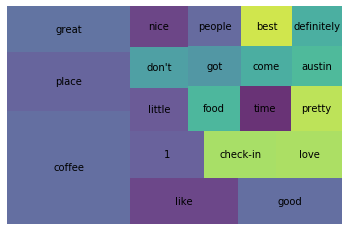

In [70]:
visualize_counts(shops, 'tokens')

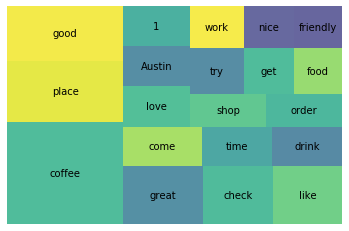

In [71]:
visualize_counts(shops, 'lemmas')

### Overall analysis:

Overall the reviews seem positive; "good," "great," "nice," "like," and "love" are in the top 20 using both methods, while "pretty" shows up in the tokens and "friendly" in the lemmas. "Austin" also shows up using both methods; presumably, these coffeeshops are in Austin.

There are also some words that should probably be dropped as noise in a more rigorous analysis, such as "place," "coffee," "come," etc.

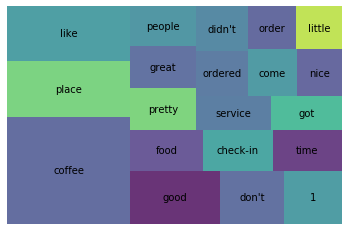

In [72]:
bad_ratings = shops[shops['star_rating'] < 4]

visualize_counts(bad_ratings, 'tokens')

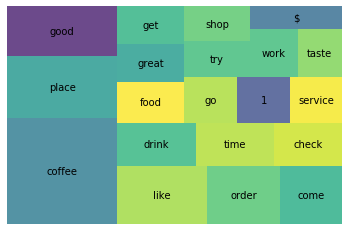

In [73]:
visualize_counts(bad_ratings, 'lemmas')

### Bad ratings analysis:

There are two aspects that jump out at me here:

1. The bad reviews seem more *specific* than the reviews as a whole. We see mentions of individual features of the coffeeshops, such as "food," "taste," "order(ed)," "service," and (in the lemma case) even a dollar sign! I hypothesize that, when someone is leaving a negative review, they are more likely to want to point out the *reasons* why they disliked the thing in question, while a regular review might just be short/general (e.g. "I enjoyed it!").

2. Even the positive words like "good" and "great" show up here as well! Probably this is because of reviews that employ something similar to a "compliment sandwich" technique, where they say what they liked *as well as* what they didn't like abou the coffeeshop in question.

Finally, I find it sort of notable that "Austin" isn't here--is there a reason people are more likely to mention the city in a positive rather than in a negative review?

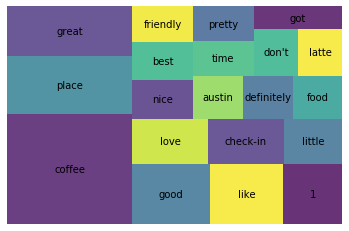

In [74]:
good_ratings = shops[shops['star_rating'] > 3]

visualize_counts(good_ratings, 'tokens')

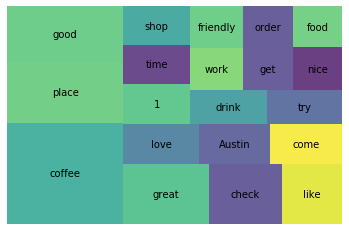

In [75]:
visualize_counts(good_ratings, 'lemmas')

### Good ratings analysis:

The good ratings seem fairly similar to the ratings as a whole when it comes to word usage; not a surprise, since there are far more good ratings than there are bad ratings. The one notable exception seems to be "latte"; does this mean the best way to get people to like your coffeeshop is to have great lattes? ...Probably not.

In [45]:
# Now I'll try analyzing by each store's average rating. To start with, let's
# examine closer the average ratings.

shops['avg_rating'].describe()

count    7616.000000
mean        4.169118
std         0.308706
min         3.370000
25%         3.930000
50%         4.170000
75%         4.360656
max         5.000000
Name: avg_rating, dtype: float64

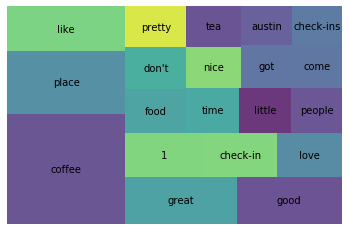

In [76]:
# Let's divide them up by the median; so any rating below 4.17 is a "good rating."

bad_averages = shops[shops['avg_rating'] < 4.17]

visualize_counts(bad_averages, 'tokens')

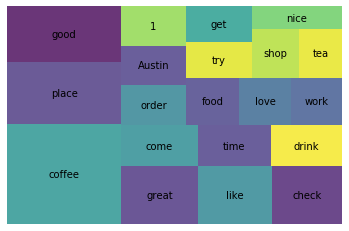

In [77]:
visualize_counts(bad_averages, 'lemmas')

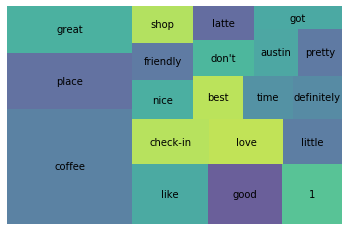

In [78]:
good_averages = shops[shops['avg_rating'] >= 4.17]

visualize_counts(good_averages, 'tokens')

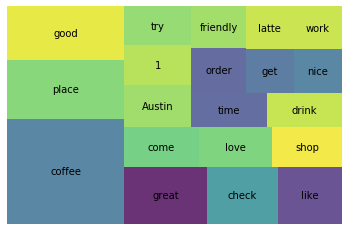

In [79]:
visualize_counts(good_averages, 'lemmas')

### Average ratings analysis:

When we divide up by each store's average rating, I don't really notice any difference between the stores with an average above the median (4.17) and those with an average rating below it. This suggests that reviews mainly differ by the reviewer's personal opinion of the store, and not the public's overall judgment of it. (Which makes sense!)

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [80]:
# To answer this problem, I need to manipulate the wc tables of both the
# "good ratings" dataframe and the "bad ratings" dataframe.
# (I'll do this twice, once for tokens and once for lemmas.)

wc_token_bad = count(bad_ratings['tokens'])

wc_token_good = count(good_ratings['tokens'])

wc_token_bad.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
17,coffee,827,1637,1.0,0.019166,0.019166,0.560298
74,place,597,875,2.0,0.010244,0.029410,0.404472
1,like,548,834,3.0,0.009764,0.039175,0.371274
4,good,441,599,4.0,0.007013,0.046188,0.298780
202,don't,340,430,5.0,0.005034,0.051222,0.230352


In [81]:
# I want to merge these dataframes together. But to keep the columns distinct,
# I'll label them beforehand (except for 'word', which is what I'll merge them on.)

bad_columns = ['word']
for column in wc_token_bad.columns:
    if column == 'word':
        continue
    else:
        bad_columns.append(f'bad_{column}')
    
bad_columns

['word',
 'bad_appears_in',
 'bad_count',
 'bad_rank',
 'bad_pct_total',
 'bad_cul_pct_total',
 'bad_appears_in_pct']

In [82]:
wc_token_bad.columns = bad_columns

good_columns = ['word']
for column in wc_token_good.columns:
    if column == 'word':
        continue
    else:
        good_columns.append(f'good_{column}')

wc_token_good.columns = good_columns

wc_token_bad.head()

# Success!

,word,bad_appears_in,bad_count,bad_rank,bad_pct_total,bad_cul_pct_total,bad_appears_in_pct
17,coffee,827,1637,1.0,0.019166,0.019166,0.560298
74,place,597,875,2.0,0.010244,0.029410,0.404472
1,like,548,834,3.0,0.009764,0.039175,0.371274
4,good,441,599,4.0,0.007013,0.046188,0.298780
202,don't,340,430,5.0,0.005034,0.051222,0.230352


In [83]:
wc2_token = wc_token_bad.merge(wc_token_good, on='word')

wc2_token.head()

# Success!

,word,bad_appears_in,bad_count,bad_rank,bad_pct_total,bad_cul_pct_total,bad_appears_in_pct,good_appears_in,good_count,good_rank,good_pct_total,good_cul_pct_total,good_appears_in_pct
0,coffee,827,1637,1.0,0.019166,0.019166,0.560298,3383,6421,1.0,0.021418,0.021418,0.550977
1,place,597,875,2.0,0.010244,0.029410,0.404472,2432,3389,2.0,0.011305,0.032723,0.396091
2,like,548,834,3.0,0.009764,0.039175,0.371274,1486,2068,5.0,0.006898,0.056573,0.242020
3,good,441,599,4.0,0.007013,0.046188,0.298780,1643,2180,4.0,0.007272,0.049674,0.267590
4,don't,340,430,5.0,0.005034,0.051222,0.230352,793,965,18.0,0.003219,0.107444,0.129153


In [84]:
# Now to calculate the differences. I also have to take the absolute value, of course.

differences = []

for i in range(len(wc2_token)):
    diff = wc2_token.loc[i, 'bad_pct_total'] - wc2_token.loc[i, 'good_pct_total']
    ab_diff = abs(diff)
    differences.append(ab_diff)
    
wc2_token['pct_total_diff'] = differences

wc2_token = wc2_token.sort_values(by='pct_total_diff', ascending=False)

wc2_token.head()

,word,bad_appears_in,bad_count,bad_rank,bad_pct_total,bad_cul_pct_total,bad_appears_in_pct,good_appears_in,good_count,good_rank,good_pct_total,good_cul_pct_total,good_appears_in_pct,pct_total_diff
10,great,264,348,11.0,0.004074,0.076535,0.178862,2174,2902,3.0,0.009680,0.042403,0.354072,0.005606
26,love,171,202,27.0,0.002365,0.124432,0.115854,1263,1604,7.0,0.005350,0.067423,0.205700,0.002985
2,like,548,834,3.0,0.009764,0.039175,0.371274,1486,2068,5.0,0.006898,0.056573,0.242020,0.002866
173,best,64,72,174.0,0.000843,0.322742,0.043360,951,1093,11.0,0.003646,0.084188,0.154886,0.002803
0,coffee,827,1637,1.0,0.019166,0.019166,0.560298,3383,6421,1.0,0.021418,0.021418,0.550977,0.002252


In [85]:
# Let's make sure I did the absolute value correctly.

wc2_token.tail()

# Success!

,word,bad_appears_in,bad_count,bad_rank,bad_pct_total,bad_cul_pct_total,bad_appears_in_pct,good_appears_in,good_count,good_rank,good_pct_total,good_cul_pct_total,good_appears_in_pct,pct_total_diff
4732,"popular,",2,2,5343.0,0.000023,0.865089,0.001355,7,7,4778.0,0.000023,0.833528,0.001140,6.639112e-08
4737,this?,2,2,5349.0,0.000023,0.865230,0.001355,7,7,4837.0,0.000023,0.834906,0.001140,6.639112e-08
5072,stepping,2,2,5792.0,0.000023,0.875603,0.001355,6,7,4904.0,0.000023,0.836470,0.000977,6.639112e-08
4740,a/c,2,2,5354.0,0.000023,0.865347,0.001355,6,7,5052.0,0.000023,0.839926,0.000977,6.639112e-08
5199,present,2,2,5942.0,0.000023,0.879115,0.001355,7,7,4735.0,0.000023,0.832524,0.001140,6.639112e-08


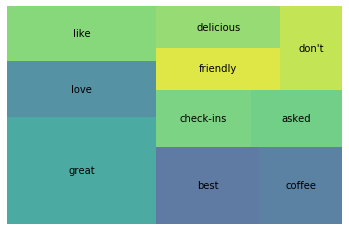

In [86]:
# If I reset the index, it's a lot easier to take the "top 10 differences."

wc3_token = wc2_token.reset_index(drop=True)

wc3_token_top10 = wc3_token.loc[0:9]

squarify.plot(sizes=wc3_token_top10['pct_total_diff'], label=wc3_token_top10['word'], alpha=.8)
plt.axis('off')
plt.show()

In [87]:
# I think it'd be more helpful to make a line graph that shows each word's
# percentage frequency in the positive and negative reviews.
# To do this, it's easiest to make a new dataframe with all the necessary information.

words = wc3_token_top10['word'].tolist()

words

['great',
 'love',
 'like',
 'best',
 'coffee',
 'check-ins',
 'asked',
 'friendly',
 'delicious',
 "don't"]

In [88]:
df_token = pd.DataFrame()

df_token['word'] = words

df_token = df_token.merge(wc2_token, on='word')

print(df_token.shape)

df_token.head()

(10, 14)


,word,bad_appears_in,bad_count,bad_rank,bad_pct_total,bad_cul_pct_total,bad_appears_in_pct,good_appears_in,good_count,good_rank,good_pct_total,good_cul_pct_total,good_appears_in_pct,pct_total_diff
0,great,264,348,11.0,0.004074,0.076535,0.178862,2174,2902,3.0,0.009680,0.042403,0.354072,0.005606
1,love,171,202,27.0,0.002365,0.124432,0.115854,1263,1604,7.0,0.005350,0.067423,0.205700,0.002985
2,like,548,834,3.0,0.009764,0.039175,0.371274,1486,2068,5.0,0.006898,0.056573,0.242020,0.002866
3,best,64,72,174.0,0.000843,0.322742,0.043360,951,1093,11.0,0.003646,0.084188,0.154886,0.002803
4,coffee,827,1637,1.0,0.019166,0.019166,0.560298,3383,6421,1.0,0.021418,0.021418,0.550977,0.002252


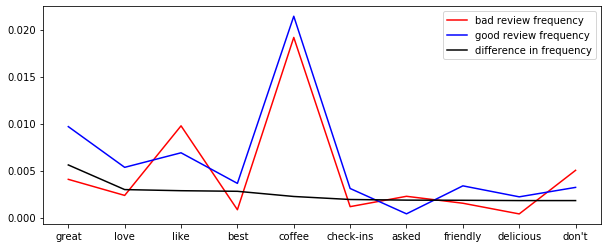

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)

ax.plot(range(10), df_token['bad_pct_total'], color='red', label='bad review frequency')
ax.plot(range(10), df_token['good_pct_total'], color='blue', label='good review frequency')
ax.plot(range(10), df_token['pct_total_diff'], color='black', label='difference in frequency')
ax.set_xticks(range(10))
ax.set_xticklabels(words)
ax.legend()
plt.show()

### Analysis (tokens):

The above ten words are those that have the greatest difference between their frequency in positive reviews and their frequency in negative reviews. One might expect these to be a mix of positive and negative words, but they actually aren't; most are positive (great, love, like, best, friendly, delicious)--and what is possibly even more notable, "like" shows up more often in negative reviews than in positive reviews! I can think of two possible explanations for this: 'like' is a less positive word than 'love,' so if I'm leaving a negative review but want to mention the positive aspects, I'm more likely to use 'like' than when I'm gushing. Alternately, 'like' is often used as an intensifier ("she's so, like, cool!"), and perhaps these reviews use it in that sense or similar ones rather than as the literal "I have positive feelings toward this thing" sense. The former explanation seems more likely to me, though.

What words are here other than those positive ones?

* "coffee": One of the most common words period shows up somewhat more often in positive reviews than in negative ones. While this may just be statistical noise, it may also be a sign that people who like a coffeeshop think of its coffee, while those who dislike it may think more of other aspects of the store (e.g. food, service, decor).

* "check-ins": Some reviews state the number of "check-ins" beforehand; I'm not entirely sure what this means, and it should probably be removed in a more detailed analysis. That said, the fact that it shows up more often in positive than in negative reviews may be important.

* "asked": This word shows up more often in negative reviews. Perhaps these unhappy customers are complaining that they asked for something but didn't get it.

* "don't" This appears to be the sole 'negative' word in the top 10. An interesting question is why almost all these words are positive, not negative. Perhaps it's similar to [this Tolstoy quote](https://en.wikipedia.org/wiki/Anna_Karenina_principle): All happy reviews are alike; each unhappy review is unhappy in its own way.

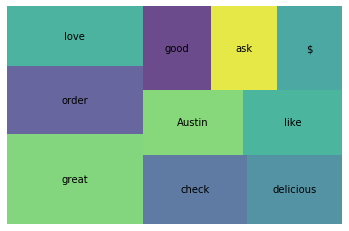

In [90]:
# Now I'll do it for lemmas. This is just doing the same thing I already did, so let's go through it fast.

wc_lemma_bad = count(bad_ratings['lemmas'])
wc_lemma_good = count(good_ratings['lemmas'])

wc_lemma_bad.columns = bad_columns
wc_lemma_good.columns = good_columns

wc2_lemma = wc_lemma_bad.merge(wc_lemma_good, on='word')

differences = []
for i in range(len(wc2_lemma)):
    diff = wc2_lemma.loc[i, 'bad_pct_total'] - wc2_lemma.loc[i, 'good_pct_total']
    ab_diff = abs(diff)
    differences.append(ab_diff)
wc2_lemma['pct_total_diff'] = differences
wc2_lemma = wc2_lemma.sort_values(by='pct_total_diff', ascending=False)

wc3_lemma = wc2_lemma.reset_index(drop=True)
wc3_lemma_top10 = wc3_lemma.loc[0:9]

squarify.plot(sizes=wc3_lemma_top10['pct_total_diff'], label=wc3_lemma_top10['word'], alpha=.8)
plt.axis('off')
plt.show()

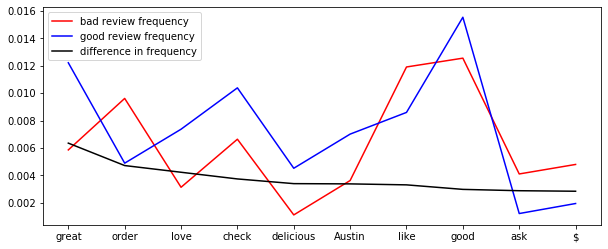

In [94]:
words = wc3_lemma_top10['word'].tolist()

df_lemma = pd.DataFrame()
df_lemma['word'] = words
df_lemma = df_lemma.merge(wc2_lemma, on='word')

fig, ax = plt.subplots()
fig.set_size_inches(10,4)

ax.plot(range(10), df_lemma['bad_pct_total'], color='red', label='bad review frequency')
ax.plot(range(10), df_lemma['good_pct_total'], color='blue', label='good review frequency')
ax.plot(range(10), df_lemma['pct_total_diff'], color='black', label='difference in frequency')
ax.set_xticks(range(10))
ax.set_xticklabels(words)
ax.legend()
plt.show()

### Analysis (lemmas):

There are some new words now that aren't in the tokens list. Let's go through them one at a time.

* "order": I would guess this is similar to 'ask,' in that these unhappy customers are complaining about an order that didn't turn out right. (I guess it's kind of weird to say "My order came back exactly as I requested!", since that's assumed to be the natural outcome.)

* "check": This surprises me. Why would positive reviews say "check" so much more often than negative reviews? I would have to see some examples of usage before I can draw conclusions, because the word can mean so many different things.

* "Austin": As I mentioned in an earlier analysis, I would guess this word shows up because you're more likely to say something like "This is the best coffee shop in Austin / if you're in Austin, definitely stop by!" rather than "if you're in Austin, stay away!"

* "$": Finally, the humble dollar sign shows up in the lemmas! Most likely, negative reviewers are complaining about the cost. An interesting question is why so few positive reviews use the dollar sign; maybe praising a coffeeshop for being cheap is rarer than criticizing it for being expensive?

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 



In [11]:
# I tried converting to sqlite, but I kept getting an error for my insert_row query.
# Keeping this code for posterity, but don't run it!!

import sqlite3

conn = sqlite3.connect('coffeeshop_db2.sqlite3')
curs = conn.cursor()

create_table = """
CREATE TABLE review_data (
    id INTEGER PRIMARY KEY,
    name VARCHAR,
    review VARCHAR,
    rating INT)
"""

curs.execute(create_table)

for i in range(len(shops)):
    name = shops.loc[i, 'coffee_shop_name']
    review = shops.loc[i, 'full_review_text']
    rating = shops.loc[i, 'star_rating']
    insert_row = f"INSERT INTO review_data (name, review, rating) \
    VALUES ({name}, {review}, {rating});"
    curs.execute(insert_row)
    
query = """SELECT name, AVG(rating)
    FROM review_data
    GROUP BY name;
"""

results = curs.execute(query).fetchall()

results

OperationalError: near "Factory": syntax error